In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Found 6528 images belonging to 51 classes.
Found 816 images belonging to 51 classes.
Epoch 1/50
204/204 [==============================] - ETA: 0s - loss: 4.0726 - accuracy: 0.0035
Epoch 00001: saving model to /content/drive/My Drive/models/06/ResNet152/ckpts/cp-0001.ckpt
204/204 [==============================] - 1296s 6s/step - loss: 4.0726 - accuracy: 0.0035 - val_loss: 3.9320 - val_accuracy: 0.0196
Epoch 2/50
204/204 [==============================] - ETA: 0s - loss: 3.9353 - accuracy: 0.0049
Epoch 00002: saving model to /content/drive/My Drive/models/06/ResNet152/ckpts/cp-0002.ckpt
204/204 [==============================] - 1279s 6s/step - loss: 3.9353 - accuracy: 0.0049 - val_loss: 3.9320 - val_accuracy: 0.0196
Epoch 3/50
204/204 [==============================] - ETA: 0s - loss: 3.9353 - accuracy: 0.0147
Epoch 00003: saving model to /content/drive/My Drive/models/06/ResNet152/ckpts/cp-0003.ckpt
204/204 [==============================] - 1270s 6s/step - loss: 3.9353 - accuracy: 0

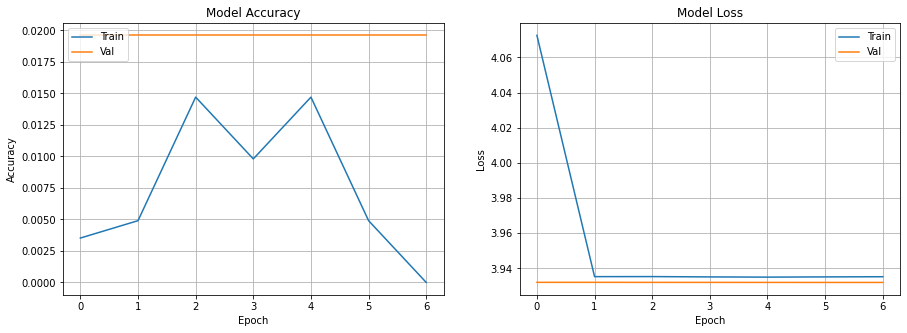

In [3]:

# -----------------------------------------------------------------------------
# Trains a model based on ResNet152.
#
# author: Pablo Salgado
# contact: pabloasalgado@gmail.com
#
# https://unir-tfm-cec.s3.us-east-2.amazonaws.com/models/06/ResNet152.tar.gz

import os

import tensorflow as tf

import common
import generators

# Parameters
TIME_STEPS = 16
EPOCHS = 50
MDL_PATH = '/content/drive/My Drive/models/06/ResNet152'

os.makedirs(MDL_PATH, exist_ok=True)

CKP_PATH = MDL_PATH + '/ckpts/cp-{epoch:04d}.ckpt'
LOG_PATH = MDL_PATH + '/training.csv'
PLT_PATH = MDL_PATH + '/plot.png'
SVD_PATH = MDL_PATH + '/model'

# Configure callbacks
CALLBACKS = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CKP_PATH,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        filename=LOG_PATH
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=2
    )
]


def build_model():
    # Load ResNet152 model excluding top.
    pre_model = tf.keras.applications.ResNet152(
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Allows to retrain last convolutional layer.
    for layer in pre_model.layers[:-4]:
        layer.trainable = False

    # Build the new CNN adding a layer to flatten the convolution as required
    # to 1D for the RNN.
    cnn_model = tf.keras.models.Sequential(
        [
            pre_model,
            tf.keras.layers.GlobalMaxPool2D()
        ]
    )

    # Now build the RNN model.
    rnn_model = tf.keras.models.Sequential()

    # Process n frames, each of 224x244x3
    rnn_model.add(tf.keras.layers.TimeDistributed(cnn_model, input_shape=(TIME_STEPS, 224, 224, 3)))

    # Build the classification layer.
    rnn_model.add(tf.keras.layers.LSTM(64))
    rnn_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    rnn_model.add(tf.keras.layers.Dropout(0.5))
    rnn_model.add(tf.keras.layers.Dense(51, activation='softmax'))

    rnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=['accuracy']
    )

    return rnn_model


def train():
    # Download and split data.
    common.split_data(TIME_STEPS)

    # Build and compile the model.
    model = build_model()

    # model.save_weights(CKP_PATH.format(epoch=0))

    # Load last checkpoint if any.
    # model.load_weights(
    #     tf.train.latest_checkpoint(
    #         os.path.dirname(CKP_PATH)
    #     )
    # )

    train_idg = generators.TimeDistributedImageDataGenerator(
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        rescale=1. / 255,
        time_steps=TIME_STEPS,
    )

    validation_idg = generators.TimeDistributedImageDataGenerator(
        time_steps=TIME_STEPS,
    )

    history = model.fit(
        train_idg.flow_from_directory(
            common.TRAIN_DATA_PATH,
            target_size=(224, 224),
            batch_size=32,
            class_mode='sparse',
            shuffle=False,
            # classes=['agree_pure', 'agree_considered'],
            # save_to_dir='./data/train'
        ),
        validation_data=validation_idg.flow_from_directory(
            common.VALIDATION_DATA_PATH,
            target_size=(224, 224),
            batch_size=32,
            class_mode='sparse',
            shuffle=False,
            # classes=['agree_pure', 'agree_considered'],
            # save_to_dir='./data/test'
        ),
        callbacks=CALLBACKS,
        epochs=EPOCHS,
    )

    model.save(SVD_PATH)

    common.plot_acc_loss(history, PLT_PATH)


if __name__ == '__main__':
    train()
